<a href="https://colab.research.google.com/github/HDev-NET/CNN/blob/main/CNN_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Kết nối với Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Chạy xong thì comment lại
%cd "/content/drive/MyDrive/CNN/CNN/"

/content/drive/MyDrive/CNN/CNN


# **Giải thích thư viện**
`import numpy as np` Xử lý một số toán học

`import matplotlib.pyplot as plt`  Thư viện đồ thị trực quan, hình ảnh,...

`from pathlib import Path`

`import os`

`import cv2`   Xử lý chuyển đổi đồng nhất kích thước, màu sắc ảnh

`import random`

`import pickle`  Lưu 

`import tensorflow as tf`

`from tensorflow.keras.models import Sequential`   Khỏi tạo một mô hình neural network

`from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D`

`Dense` là tạo một layer

`Activation` là hàm kích hoạt

`Flatten` là layer làm phẳng từ ma trân m x n sang ma tran 1 x k

`Conv2D` ~ Convolutional 2D mạng tích chập 2 chiều

`MaxPool2D` là hàm tinh giảm số neural

`from tensorflow.keras.utils import to_categorical`  One hot

`from sklearn.model_selection import train_test_split`   train test validation

In [ ]:
import numpy as np # Xử lý một số toán học
import matplotlib.pyplot as plt # Thư viện đồ thị trực quan, hình ảnh,...
from pathlib import Path
import os
import cv2 
import random
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

`data_dir = Path(data_dir)`    Chuyển đường dẫn đến dataset thành một Path Object

`categories = os.listdir(data_dir)` 
 Vì cấu trúc file là :

```
path/to/image_dir/
  split_name/  # Ex: 'train'
      label1/  # Ex: 'airplane' or '0015'
          xxx.png
          xxy.png
          xxz.png
      label2/
          xxx.png
          xxy.png
          xxz.png
      split_name/  # Ex: 'test'

```
=> nên ta muốn lưu toàn bộ label vào trong categories

Bộ dữ liệu này có tới 17 label; `80 samples/1 label => có 80 * 17 = 1360` samples

Chạy lênh sau để in ra số ảnh trong dataset:
```
count_image = len(list(data_dir.glob("*/*.jpg")))
print(count_image)
```
jpg là đuôi ảnh, */*.jpg nghĩa là ngay sau đường dẫn đễn dataset * đầu tiên là mở toàn bộ folder ngay cùng cấp ngay sau đó (tức là label1, label2, ...) / * là chọn tất cả tên file với đuôi là jpg. Trong trường hợp ảnh có nhiều loài thì chọn `.*` để chọn toàn bộ loại ảnh (cần lưu ý dữ liệu lúc này có chắc chắn toàn bộ ảnh hay không, hoặc là design theo những đuôi ảnh nhất định thì tốt hơn)

Chạy: `print(len(categories))` để xem số lượng label


In [ ]:
data_dir = "/content/drive/MyDrive/CNN/CNN/dataset/colab"
data_dir = Path(data_dir)  
categories = os.listdir(data_dir) 

In [ ]:
count_image = len(list(data_dir.glob("*/*.tif")))
print(count_image)
print(len(categories))

573
4


In [ ]:
categories.index('Daffodil')

0

# **Quá trình tạo tập dữ liệu**

In [ ]:
training_data = []  # Toàn bộ dữ liệu chúng ta có thể sử dụng, phân biệt giữa training data, x_train, y_train, x_test, y_test, x_val và y_val
# training data = [x_train, y_train] + [x_test, y_test] + [x_val, y_val]

IMG_SIZE = 200  # Trong hướng dẫn này, lựa chọn đưa toàn bộ ảnh về cùng kích thước 200 x 200, (bộ dữ liệu với nhiều loại kích thước ảnh)
def create_training_data():
  for category in categories: # Duyệt qua từng folder label
    path = os.path.join(data_dir, category) # tạo một path tạm đến folder label đó 
    label_number = categories.index(category) # label thứ mấy trong mảng categories chứa các label
    for img in os.listdir(path):  # duyệt qua toàn bộ ảnh trong path
      try:
        img_array_gray = cv2.imread(os.path.join(path, img), cv2.IMREAD_ANYCOLOR) # Đọc mảng giá trị của ảnh, ở đây không chuyển ảnh thành gray
        new_img_array = cv2.resize(img_array_gray, (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_AREA)  # Chuyển ảnh về cùng kích thước
        training_data.append([new_img_array, label_number])
        print(len(training_data)) # Lưu ảnh cùng label tương ứng vào training_data
      except Exception as e:
        pass

create_training_data()


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
print(training_data[1])

[array([[[217, 190, 227],
        [175, 122, 198],
        [230, 219, 234],
        ...,
        [180, 129, 199],
        [159, 100, 163],
        [168, 129, 185]],

       [[204, 172, 211],
        [167, 114, 188],
        [230, 218, 234],
        ...,
        [176, 124, 198],
        [180, 128, 199],
        [165, 123, 184]],

       [[206, 173, 204],
        [161, 106, 177],
        [225, 211, 233],
        ...,
        [189, 144, 208],
        [184, 135, 205],
        [169, 127, 186]],

       ...,

       [[238, 233, 238],
        [237, 232, 239],
        [239, 233, 239],
        ...,
        [153,  93, 160],
        [172, 120, 198],
        [172, 135, 196]],

       [[238, 232, 239],
        [239, 232, 240],
        [239, 232, 239],
        ...,
        [170, 118, 193],
        [182, 132, 211],
        [176, 139, 195]],

       [[238, 232, 239],
        [238, 233, 239],
        [237, 231, 239],
        ...,
        [181, 135, 208],
        [194, 155, 219],
        [198, 179, 207]

In [ ]:
random.shuffle(training_data) # xáo trộn dữ liệu

In [ ]:
# Tạo 2 mảng để lưu samples và labels theo cùng index tương ứng
X = []  # samples
y = []  # labels

In [ ]:
for feature, label in training_data:  # Mỗi phần tử trong training_data có dạng [feature, label] trong đó feature = new_img_array và label = label_number
  X.append(feature)
  y.append(label)
  print(y)
# X bây giờ chứa toàn bộ features
# Chuyển X về dạng ma trận
# -1 ở đây tương đương với số lượng features, dùng -1 numpy tự hiểu là ứng với số lượng của feature hiện có trong X
# Vì không chuyển thành ảnh trắng đen nên ảnh có 3 kênh màu, tham số cuối cùng trong reshape
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

[0]
[0, 0]
[0, 0, 1]
[0, 0, 1, 0]
[0, 0, 1, 0, 2]
[0, 0, 1, 0, 2, 2]
[0, 0, 1, 0, 2, 2, 2]
[0, 0, 1, 0, 2, 2, 2, 0]
[0, 0, 1, 0, 2, 2, 2, 0, 1]
[0, 0, 1, 0, 2, 2, 2, 0, 1, 1]
[0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0]
[0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 2]
[0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 2, 0]
[0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0]
[0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0, 3]
[0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0, 3, 3]
[0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0, 3, 3, 3]
[0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0, 3, 3, 3, 3]
[0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0, 3, 3, 3, 3, 0]
[0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0, 3, 3, 3, 3, 0, 0]
[0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0, 3, 3, 3, 3, 0, 0, 1]
[0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0, 3, 3, 3, 3, 0, 0, 1, 3]
[0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0, 3, 3, 3, 3, 0, 0, 1, 3, 0]
[0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0, 3, 3, 3, 3, 0, 0, 1, 3, 0, 1]
[0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0, 3, 3, 3, 3, 0, 0, 1, 3, 0, 1, 0]


In [ ]:
# Bước này dùng để lưu X và y vào một file theo định dạng có cấu trúc để khỏi phải chạy lại hàm tạo X, y phía trên - khá tốn thời gian cho việc tạo lại từ đầu
pickle_out = open("/content/drive/MyDrive/CNN/CNN/X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/CNN/CNN/y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [ ]:
# Đọc lại file cấu trúc đã lưu
pickle_in = open("/content/drive/MyDrive/CNN/CNN/X.pickle", "rb")
X = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("/content/drive/MyDrive/CNN/CNN/y.pickle", "rb")
y = pickle.load(pickle_in)
pickle_in.close()

In [ ]:
X = X/255  # Tinh giảm giá trị trong điểm ảnh (vì giá trị màu chạy từ 0 --> 255 nên mới có con số 255 ở đây)
y = to_categorical(y) # one hot
# ví dụ y_number = 14 thì y = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

# **Xây dựng model**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
activation_6 (Activation)    (None, 200, 200, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 98, 98, 64)        18496     
_________________________________________________________________
activation_7 (Activation)    (None, 98, 98, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 47, 47, 128)      

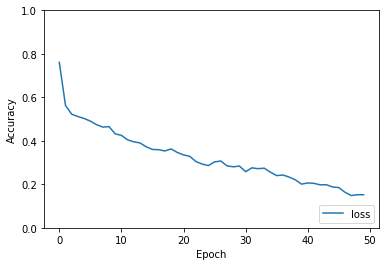

In [ ]:
model = Sequential() #  Khởi tạo một một mô hình neural

# Bắt đầu của mạng thêm một Convolutional layer với các tham số trên
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
# Lớp ban đầu này phải truyền cho mạng biết input_shape ban đầu là bao nhiêu chính là (weight x heigh x depth) của ảnh
# padding chỉ có thể chọn 1 trong 2 giá trị `same` hoặc `valid`
model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=X.shape[1:], padding="same"))

# Thêm cho layer trên một hàm kích hoạt
model.add(Activation("relu"))
# Tinh giảm số neural của output nếu cần thiết
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3,3)))
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

# model.add(Conv2D(filters=256, kernel_size=(3,3)))
# model.add(Activation("sigmoid"))
# model.add(MaxPool2D(pool_size=(2,2),strides=2))

# Làm phẳng neuron, bắt đầu fully connected
model.add(Flatten())
# Tạo một layer
model.add(Dense(128))
# Thêm hàm kích hoạt
model.add(Activation("relu"))

model.add(Dense(64))
model.add(Activation("relu"))
# output
model.add(Dense(len(categories)))
model.add(Activation("softmax"))

# Cung cấp cho mô hình hàm loss function lựa chọn, thuật toán tối ưu
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary() # xem chi tiết mô hình xây dựng của chính mình

# Cuối cùng đào tạo nó
# model.fit(X, y, batch_size=200, epochs=14)
plt.plot(model.fit(X, y, batch_size=200, epochs=50).history['loss'], label='loss')
# plt.plot(model.fit(X, y, batch_size=200, epochs=14).history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
# Cuối cùng là dùng một mẫu để dự đoán
y_hat = model.predict(X[500:501])
y_label = np.argmax(y_hat, axis=1)
print(y_label)
print(y[500])

[0]
[1. 0. 0. 0.]


# **Tổng kết**
Hướng dẫn trên chưa bao gồm bộ dữ liệu để train và validation.
Cách làm như sau, ban đầu từ training_data, chúng ta chia tập dữ liệu thành train và test:
 + Test để sau cùng chúng ta dự đoán và tính toán độ chính xác cuối cùng cho mô hình, hoặc bộ này được cung cấp riêng dùng để đánh giá tổng quan mô hình của mình
 + Train: trong tập này chúng ta nên chia thành train và validation, chức năng của validation giống như test, nhưng hiểu thoáng rằng trong ta không biết trong thực tế dữ liệu sẽ như thế nào - đây chính là tập test của chúng ta, còn validation chính là tập dữ liệu thực thế giả định của chúng ta - tập dữ liệu mà chúng ta mặc định rằng đã có và dùng để đánh giá độ chính xác, điều chỉnh tham số. 

Ở đây mình nói gộp, các bạn phải hiểu rằng train bao gồm cả X_train và y_train, tương tự cho test và validation. 

***Lưu ý:***
colab hỗ trợ tốt cho việc training =)))).
Code trên có tham khảo từ một số nguồn, vì chưa có thời gian nên chưa ghi nguồn vào được, về sau sẽ cập nhật chi tiết và trích dẫn nguồn.

Vì hướng dẫn này làm trong phút chót nên chỉ ngắn gọn thế thôi, mong rằng giúp ích được cho cách bạn.